In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('/pio/scratch/1/i313924/data/train_data/slim_ratings.csv',
                 names=['asin', 'reviewerID', 'overall', 'unixReviewTime'])
df = df.rename(columns={"reviewerID": "u_id", "asin": "i_id", "overall": "rating"})

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/svd_data/model_1000_epochs_regularized.pkl')

In [11]:
pred = model.predict(df)
mae = mean_absolute_error(df['rating'], pred)

In [12]:
mae

0.03545148701126149

## ABX

In [4]:
item_mapping = {v: k for k, v in model.item_mapping_.items()}
items_embeddings = pd.DataFrame(model.qi_)
items_embeddings = items_embeddings.rename(index=item_mapping)

In [25]:
def analyse_ABX(path, tsne = None, pca = None):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 100))
    B = np.zeros((10000, 100))
    X = np.zeros((10000, 100))

    for i, test in tqdm(abx_tests.iterrows()):
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in tqdm(range(10000)):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    if tsne is not None:
        tsne_A = np.zeros((10000, 2))
        tsne_B = np.zeros((10000, 2))
        tsne_X = np.zeros((10000, 2))

        for i, test in tqdm(abx_tests.iterrows()):
            tsne_A[i, :] = tsne.loc[test["A"]]
            tsne_B[i, :] = tsne.loc[test["B"]]
            tsne_X[i, :] = tsne.loc[test["X"]]


        dist_tsne_A = ((tsne_A - tsne_X)**2).sum(axis=1)
        dist_tsne_B  = ((tsne_B - tsne_X)**2).sum(axis=1)

        cos_dist_tsne_A = np.zeros(10000)
        cos_dist_tsne_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_tsne_A[i] = spatial.distance.cosine(tsne_A[i, :], tsne_X[i, :])
            cos_dist_tsne_B[i] = spatial.distance.cosine(tsne_B[i, :], tsne_X[i, :])

    print("Eucl:")
    print("Score: ", (dist_A < dist_B).mean())
    if pca is not None:
        print("PCA score: ", (dist_pca_A < dist_pca_B).mean())
        print("PCA distance match: ", ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (dist_tsne_A < dist_tsne_B).mean())
        print("tSNE distance match: ", ((dist_A < dist_B) == (dist_tsne_A < dist_tsne_B)).mean())

    print("Cos:",)
    print("Score: ", (cos_dist_A < cos_dist_B).mean())
    if pca is not None:
        print("PCA score: ", (cos_dist_pca_A < cos_dist_pca_B).mean())
        print("PCA distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (cos_dist_tsne_A < cos_dist_tsne_B).mean())
        print("tSNE distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_tsne_A < dist_tsne_B)).mean())

In [27]:
analyse_ABX('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', tsne = None, pca = pca)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.5052
PCA score:  0.5292
PCA distance match:  0.6052
Cos:
Score:  0.5014
PCA score:  0.5273
PCA distance match:  0.5493


In [28]:
analyse_ABX('/pio/scratch/1/i313924/data/test_data/Suits_Dresses_ABX.json', tsne = None, pca = pca)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.5002
PCA score:  0.5191
PCA distance match:  0.6107
Cos:
Score:  0.5072
PCA score:  0.5176
PCA distance match:  0.5548


In [14]:
base = [A, B, X]
types = ["A", "B", "X"]
transformed = []
for data in base:
    transformed.append(pd.DataFrame(pca.transform(data)))
for type, data in zip(types, transformed):
    data["type"] = type
    data["idx"] = data.index

transformed = pd.concat(transformed)
transformed = transformed.sort_values(by=['idx'])

In [11]:
import plotly.express as px
import plotly.io as pio
from lets_plot import *
LetsPlot.setup_html()
pio.renderers.default = 'notebook_connected'
px.scatter(transformed[:33], x=0, y=1, animation_frame="idx", color="type", range_x=[-3, 3], range_y=[-3, 3])

## Embeddings PCA

In [16]:
item_embeddings = pd.DataFrame(model.qi_)
user_embeddings = pd.DataFrame(model.pu_)

In [17]:
item_embeddings 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.149393,0.113666,-0.129029,0.048759,-0.002672,0.104361,-0.163491,-0.040161,0.019470,-0.022390,...,0.128132,-0.042954,-0.092720,-0.053786,-0.149163,0.001591,0.012808,0.094926,-0.008355,0.060699
1,-0.040476,-0.172574,-0.151021,0.037806,-0.104254,0.102069,0.132950,-0.104080,-0.175726,0.023957,...,-0.073924,0.061887,-0.045006,-0.169282,0.037037,0.128070,0.330427,-0.119964,0.153838,-0.048285
2,-0.126284,-0.230147,0.016212,-0.123529,0.159287,-0.262785,0.023575,0.077968,0.164683,0.252367,...,0.127548,-0.108179,-0.059644,0.010145,0.317738,0.042354,-0.330321,-0.265635,0.042238,-0.250359
3,0.034778,0.115375,-0.159168,0.160235,0.064622,-0.127149,0.069086,-0.057605,0.007293,0.099979,...,0.094477,0.132071,0.111183,0.176230,-0.059571,0.279857,-0.017445,-0.248767,0.083292,-0.287604
4,0.077244,0.105341,-0.070258,0.105837,-0.048648,-0.058266,-0.041699,-0.055596,-0.163939,0.104182,...,-0.028838,0.203919,0.006130,0.022912,0.068051,0.027483,-0.064708,0.085191,0.058574,-0.010896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206491,-0.210755,0.115877,-0.018103,0.094163,0.113839,0.061496,0.085917,-0.083447,-0.135113,0.071025,...,-0.017170,-0.095605,0.131412,-0.004495,0.107774,-0.045333,-0.195532,-0.042150,0.139900,-0.046988
206492,-0.043650,-0.082347,0.035145,-0.107799,0.035754,-0.027371,0.055875,-0.188577,-0.101160,0.087843,...,0.132498,0.023331,0.125943,0.015474,0.116377,-0.042483,-0.066688,-0.096229,-0.108148,-0.088905
206493,0.137890,-0.005148,0.046959,-0.099081,-0.192472,0.012582,-0.064053,-0.026946,0.208267,0.034392,...,0.107928,0.011103,-0.063176,0.085777,-0.085683,0.146123,-0.029737,0.020841,-0.089570,0.024657
206494,-0.148218,0.137447,-0.124732,-0.068753,0.093350,-0.034842,-0.140372,0.076600,0.128780,0.003132,...,0.012795,0.135620,-0.100073,0.041713,0.159904,-0.034360,0.020821,-0.045250,0.011858,-0.112839


In [18]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [19]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [15]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

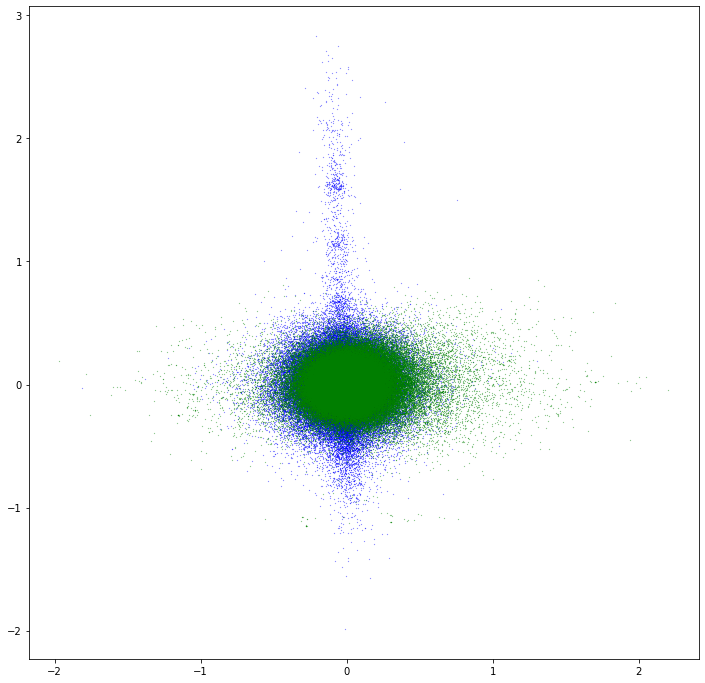

In [18]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)

In [19]:
item_mapping = {v: k for k, v in model.item_mapping_.items()}
user_mapping = {v: k for k, v in model.user_mapping_.items()}

In [20]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [21]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [22]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [23]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

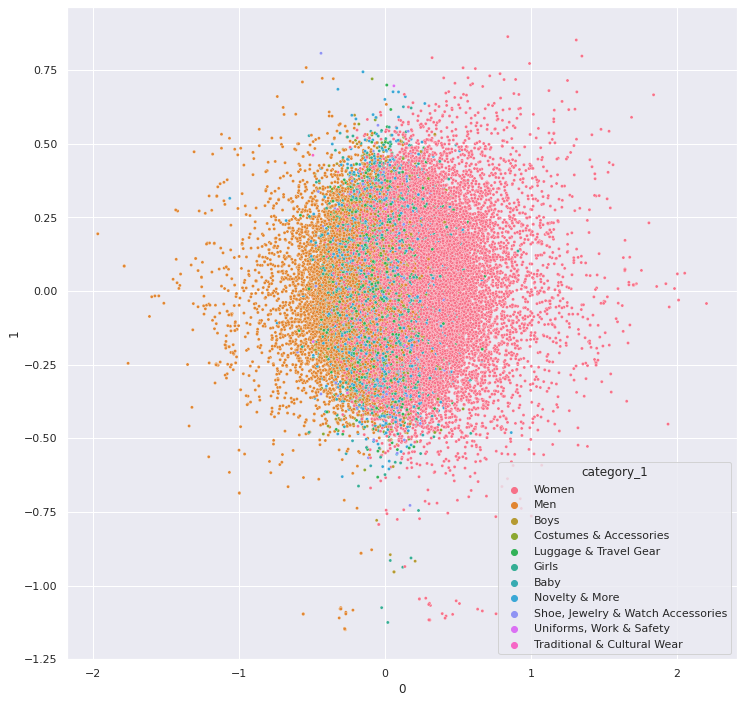

In [24]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

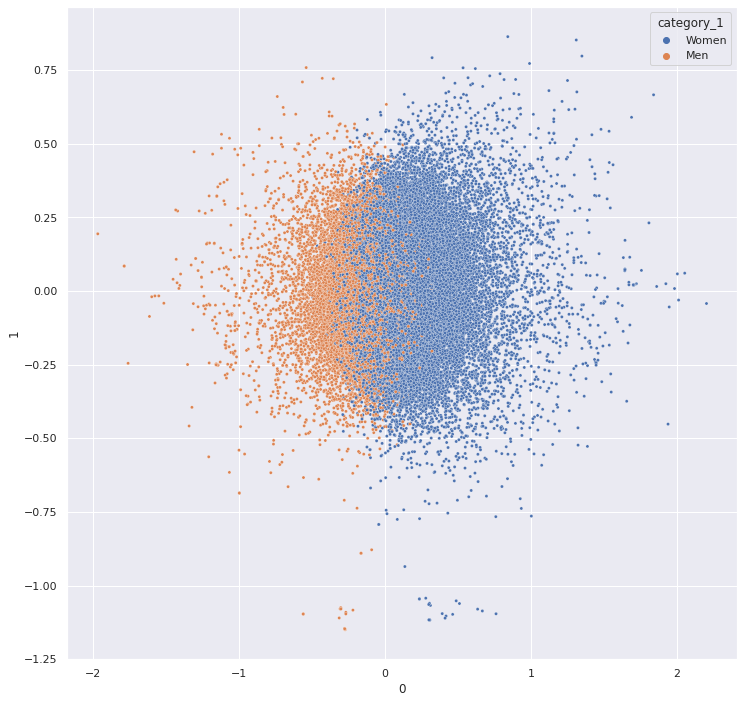

In [25]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10)

## tSNE

In [5]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)
tsne = np.load('/pio/scratch/1/i313924/data/svd_data/tsne_embeddings_1000_epochs_regularized.npy')

In [6]:
tsne = pd.DataFrame(tsne)
tsne = tsne.rename(index=item_mapping)

In [7]:
tsne = tsne.join(categories.set_index('asin'))
tsne.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


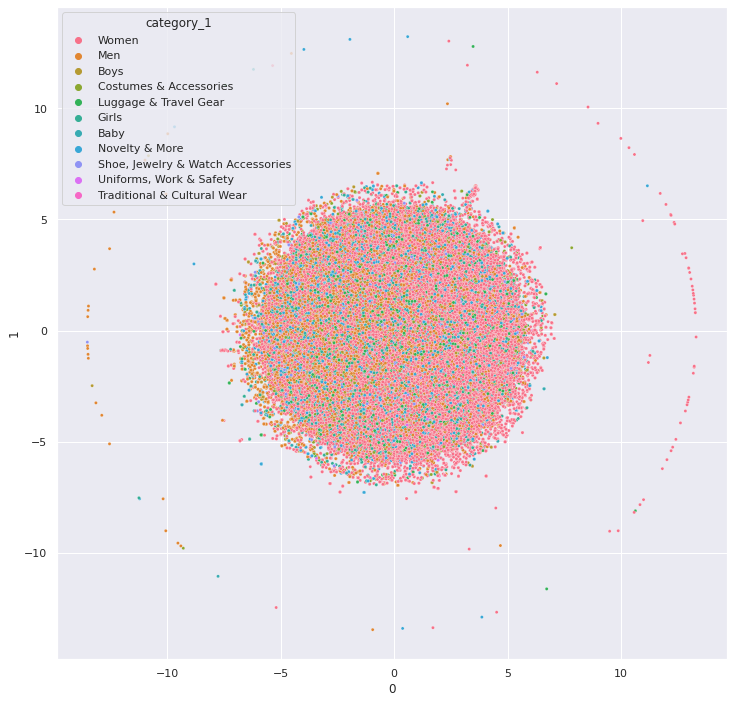

In [8]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=tsne, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

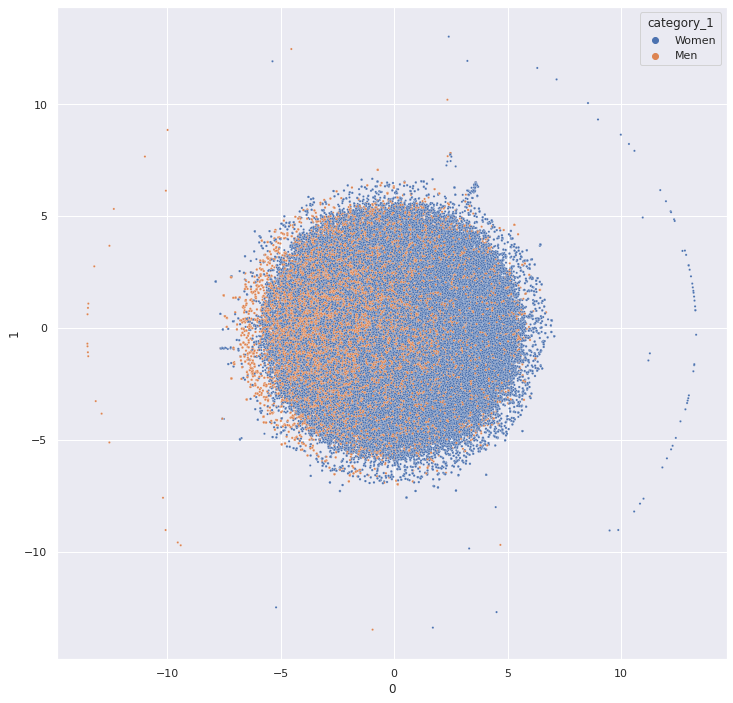

In [9]:
sns.scatterplot(x='0', y='1', data=tsne[tsne['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5)